# DS405 Homework 2
## Nick Clouse

## Imports

In [22]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sn
import swifter

import nltk
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from scipy.sparse import vstack
from scipy.sparse import hstack
from scipy import sparse
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix,mean_squared_error
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nickclouse/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nickclouse/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/nickclouse/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Exploratory Analysis

### Books data

In [3]:
books = pd.read_csv('books_data.csv')

In [5]:
print(books.columns.to_list())
for col in books.columns:
    naSum = books[col].isna().sum()
    print(f"Number of N/A entries in column '{col}': {naSum}")

['Title', 'description', 'authors', 'image', 'previewLink', 'publisher', 'publishedDate', 'infoLink', 'categories', 'ratingsCount']
Number of N/A entries in column 'Title': 1
Number of N/A entries in column 'description': 68442
Number of N/A entries in column 'authors': 31413
Number of N/A entries in column 'image': 52075
Number of N/A entries in column 'previewLink': 23836
Number of N/A entries in column 'publisher': 75886
Number of N/A entries in column 'publishedDate': 25305
Number of N/A entries in column 'infoLink': 23836
Number of N/A entries in column 'categories': 41199
Number of N/A entries in column 'ratingsCount': 162652


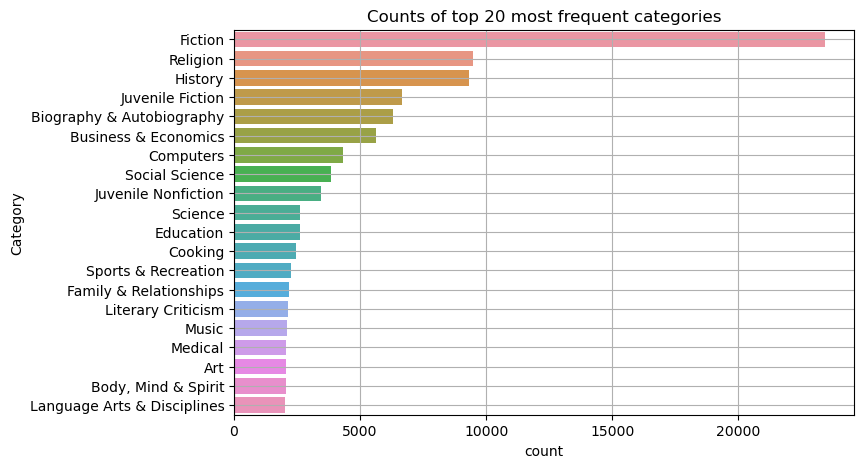

In [6]:
counts = books['categories'].value_counts().reset_index()
counts['categories'] = counts['categories'].str.replace(r"[\[\]']", '', regex=True)
counts = counts.head(20)

plt.figure(figsize=(8, 5))
sns.barplot(y="categories", x="count", data=counts)
plt.title('Counts of top 20 most frequent categories')
plt.ylabel('Category')
plt.grid()
plt.show()

### Rating Data

In [4]:
ratings = pd.read_csv('Books_rating.csv')

In [ ]:
print(ratings.columns.to_list())
print(ratings.head().to_markdown())

## Part 1: Book Recommendation
### 1.	Determine a method of identifying books that are similar to each other. You can use any data available in the “books_data.csv” file, or you can write code to gather more information about each book. 

#### a.	Write a function that allows a user to search for books similar to one that they specify. Your function should take the name of the book as a parameter and return a list of at least 5 books that are most similar (according to your metric) to the specified book.

In [72]:
booksFiltered = books.dropna(subset=['description','Title','authors'])
booksFiltered = booksFiltered.drop_duplicates(subset=['description'])
booksFiltered['combined'] = booksFiltered[['description', 'Title','authors']].agg(' '.join, axis=1)
booksFiltered = booksFiltered.reset_index(drop=True)

v = TfidfVectorizer(stop_words='english')
xTitles = v.fit_transform(booksFiltered['combined'])

book2ind = pd.Series(booksFiltered.index, index=booksFiltered['Title'])

**THE function**:

In [73]:
def getMostSimilarBook(book,n=10):
    book = book.strip()
    if book in book2ind.keys():
        idx = book2ind[book]
        scores = cosine_similarity(xTitles,xTitles[idx])
        scores = scores.flatten()

        rec = (-scores).argsort()
        rec = rec[1:n]
        return booksFiltered[['Title','authors']].iloc[rec]

#### b.	Devise a method to quantify the quality of selection of books you return.  This could include external validation (e.g. comparing your recommendations against another type of recommendation), robustness testing (e.g. comparing the recommendations of two or more of your own different models), or other types of testing.
I couldn't think of a way to properly test my function, so I just tested by picking some books and comparing the outputs on my own

In [ ]:
title = 'Object-Oriented Programming with C++ and Smalltalk'
print(getMostSimilarBook(title).to_markdown())

In [17]:
titlesToTest = booksFiltered['Title'].sample(n=10,random_state=1).to_list()

Pick 10 random books and test the function using them 

In [ ]:
for title in titlesToTest:
    i = book2ind[title]
    book = booksFiltered.iloc[i]
    title = book['Title']
    authors = book['authors']
    print('='*20)
    print(f'Getting similar books to title: {title} by {authors}')
    similarBooks = getMostSimilarBook(title)
    print('Similar Books:')
    print(similarBooks.to_markdown())


Could be better, but I think overall the model is pretty decent.

## Part 2: Composite Book Ratings
### 1.	Determine a method to rate each book based on its user reviews. You can use any data available in the “Books_ratings.csv” file.

**NOTE**: This is a cleaned up version of this part. I tried this part 3 times before finding something that was efficient and worked properly. I was originally using the whole dataset which would literally take hours to run a apply method on or vectorize, so I ended up just taking a sample of the data which was much smaller but so much easier to work with.

#### a.	Perform your own analysis on the sentiment of the reviews in the data set. Compare your sentiment scores against the reviewer’s personal ratings.


In [41]:
ratings['textSummary'] = ratings['review/text'].fillna('') + ratings['review/summary'].fillna('')

In [ ]:
ratingsSample = ratings.sample(frac=0.1,random_state=1)

In [49]:
sia = SentimentIntensityAnalyzer()

In [ ]:
# Get sentiment scores, swifter uses dask for parallel processing to apply faster
ratingsSample['SS'] = ratingsSample['textSummary'].fillna('').swifter.apply(lambda x: sia.polarity_scores(x)['compound'])

python(5956) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Pandas Apply: 100%|██████████| 300000/300000 [09:29<00:00, 526.69it/s]


In [ ]:
# Saved the sampleDF for later bc it still took forever to get sentiment scores
#ratingsSample.to_pickle('ratingsSample.pkl')

In [9]:
ratingsSample = pd.read_pickle('ratingsSample.pkl')

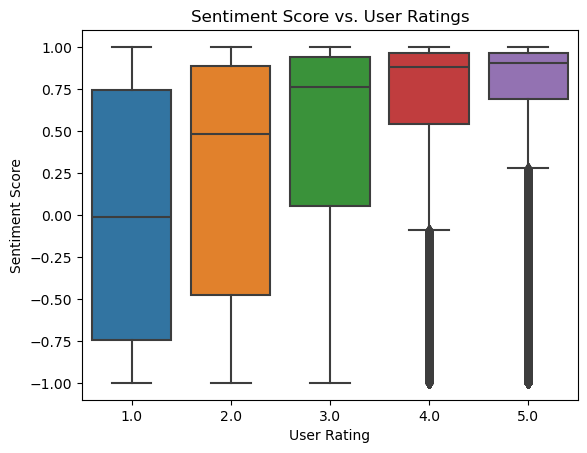

Correlation between score and SS: 0.3313583641723842


In [10]:
sns.boxplot(x=ratingsSample['review/score'], y=ratingsSample['SS'])
plt.xlabel("User Rating")
plt.ylabel("Sentiment Score")
plt.title("Sentiment Score vs. User Ratings")
plt.show()
correlation = ratingsSample['review/score'].corr(ratingsSample['SS'])
print(f'Correlation between score and SS: {correlation}')

**There isn't a big difference in sentiment scores for higher ratings, and the correlation between score and sentiment score isn't very high, so I'm going to utilize the text of the review to aid in predicting ratings**

In [47]:
stopwords = set(stopwords.words('english'))
#Function I used to tokenize text
def cleanText(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.split()
    tokens = set(text)
    tokens = [word for word in tokens if word not in stopwords]  # Remove stopwords
    tokens = [t for t in tokens if not any(c.isdigit() for c in t)]
    return ' '.join(tokens)

In [75]:
# Create Tfid vectorizer and fit transform the sample text+summary
reviewVect = TfidfVectorizer(tokenizer=cleanText)

In [ ]:
# Make X
text = ratingsSample['textSummary']
xText = reviewVect.fit_transform(text)
xSS = np.array(ratingsSample["SS"]).reshape(-1, 1)
reviewX = hstack([xText,xSS])
reviewY = ratingsSample['review/score']

#### b.	Develop a method to test the accuracy of your sentiment ratings.  This could include external validation, robustness testing, or other methods of testing.

In [78]:
xTrain,xTest,yTrain,yTest = train_test_split(reviewX,reviewY,test_size=0.2,random_state=1)
model = LogisticRegression(max_iter=500)
model.fit(xTrain,yTrain)
print("train score:", model.score(xTrain, yTrain))
print("test score:", model.score(xTest, yTest))

train score: 0.6033125
test score: 0.6076833333333334


Not the best scores, not the worst.

### 2.	Many books on the list have multiple ratings. 

#### a.	Perform an analysis on the books that takes into account all of the reader reviews for that book.

To accomplish this, I'm going to group each book by title and then use my model above to attempt to predict the scores for each rating using the text of the review and the sentiment score. I'll then find the average rating and average predicted rating and compare them using the Root Mean Squared Error (RMSE).

In [42]:
ratings['titleClean'] = ratings['Title'].fillna('').swifter.apply(lambda x: re.sub(r'[^\w\s]', '', x))

groups = ratings.groupby('titleClean')

Pandas Apply: 100%|██████████| 3000000/3000000 [00:08<00:00, 372080.09it/s]


In [43]:
uniqueBooks = ratings.drop_duplicates(subset='titleClean')
uniqueBooksSample = uniqueBooks.sample(frac=0.1,random_state=1)

Helper function to get the most frequent score in the given list. I found that this reduced the RMSE by 0.3 compared to finding the average score in the list.

In [44]:
from collections import Counter

def getMostFreqScore(numbers):
    counter = Counter(numbers)
    max_freq = max(counter.values())
    most_common_numbers = sorted([num for num, freq in counter.items() if freq == max_freq])
    return most_common_numbers[-1]

ns = [1, 2, 2, 3, 3, 3, 4, 4, 4, 4, 5,5,5,5]
print(f"The number with the highest frequency is {getMostFreqScore(ns)}")


The number with the highest frequency is 5


In [ ]:
actScores = []
predScores = []
i = 1
for title in uniqueBooksSample['titleClean']:
    print(f'{i}/{uniqueBooksSample.shape[0]}')
    i+=1
    reviews = groups.get_group(title).copy()
    text = reviews['textSummary']
    xText = v.transform(text)

    reviews.loc[:, "SS"] = reviews["textSummary"].fillna("").apply(lambda x: sia.polarity_scores(x)["compound"])
    xSS = np.array(reviews["SS"]).reshape(-1, 1)
    X = hstack([xText,xSS])
    y = reviews['review/score']

    pred = model.predict(X)
    predScore = getMostFreqScore(pred)
    actScore = getMostFreqScore(reviews["review/score"].to_list())
    actScores.append(actScore)
    predScores.append(predScore)

#### b.	Compare your sentiment scores against the average reviewer scores.  Devise a test to measure how closely your sentiment scores correlate with the user-assigned scores.

In [ ]:
print(mean_squared_error(actScores,predScores))

0.9428733835441239


The RMSE is 0.94, which means on average my predicted score is off by 0.94. Definetly could be a lot better, but given this project is already a little late I'll take it.

## Part 3: A comprehensive recommender system.

### 1.	Revise your recommendation system from part 1 to also take user reviews and ratings into account.  You’ll need to develop a new metric for your rankings by somehow combining the similarity scores and the user review/rating scores.

Plan: 
1. Get similar books 
2. Predict the ratings of each similar book
3. Sort the books by their predicted ratings (Highest to Lowest)

In [80]:
def predictScore(title):
    reviews = groups.get_group(title).copy()
    text = reviews['textSummary']
    xText = reviewVect.transform(text)

    reviews.loc[:, "SS"] = reviews["textSummary"].fillna("").apply(lambda x: sia.polarity_scores(x)["compound"])
    xSS = np.array(reviews["SS"]).reshape(-1, 1)
    xVals = hstack([xText,xSS])

    pred = model.predict(xVals)
    predScore = getMostFreqScore(pred)
    return predScore

t = re.sub(r'[^\w\s]', '', 'Object-Oriented Programming with C++ and Smalltalk')
print(predictScore(t))

5.0


In [82]:
def recommendBooks(bookTitle):
    similarBooks = getMostSimilarBook(bookTitle)
    books_and_ratings = {}
    for book in similarBooks['Title']:
        book = re.sub(r'[^\w\s]', '', book)
        score = predictScore(book)
        books_and_ratings[book] = score
    books = sorted(books_and_ratings, key=books_and_ratings.get)
    return books

print(recommendBooks(bookTitle = 'Object-Oriented Programming with C++ and Smalltalk'))

['ObjectOriented Database Design Clearly Explained', 'The Interpretation of ObjectOriented Programming Languages', 'C for Business Programmers 2ND Edition', 'Visual ObjectOriented Programming Using Delphi With CDROM SIGS Advances in Object Technology', 'Data Structures and Software Development in an Object Oriented Domain Eiffel Edition Object and Component Technology Series', 'Principles of ObjectOriented Analysis and Design', 'Programming with Microsoft Visual Basic NET An ObjectOriented Approach Introductory', 'Understanding ObjectOriented Programming with Java', 'SymbolicC An Introduction to Computer Algebra using ObjectOriented Programming']


### 2.	Write a program that a person can use to access your recommendations.  You can choose whether you want your program to be console, GUI, or web based.  Regardless of your choice, your program should be user-friendly and should not require the user to modify any of your code.

I'm going to attempt to make a web based program (This took so much longer than I though it would...)